# Topic Modeling

## Overview

A topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. During this project we chose to apply a Latent Dirichlet Allocation (LDA) technique. LDA topic modelling discovers topics that are hidden (latent) in a set of text documents. It does this by inferring possible topics based on the words in the documents using a generative probabilistic model and Dirichlet distributions. The number of topics is chosen in advance by the user and can be varied using a slider in our deployed app.

This notebook will include the following sections:

- Libraries and data importation.
- Data cleaning.
- Data Pre-processing.
- Modeling.
- Topic visualization.

##1.0 Import Libraries



We will download pyLDA a library designed to help users interpret the topics in a topic model that has been fit to a corpus of text data

In [ ]:
import pandas as pd ## dataset manipulation
import re ## regular expressions
from wordcloud import wordcloud ## plotting wordclouds
import matplotlib.pyplot as plt ## Plotting

from sklearn.feature_extraction.text import CountVectorizer ## transform a given text into a vector on the basis of the frequency
from sklearn.decomposition import LatentDirichletAllocation ## LDA model from sklearn

In [ ]:
#!pip install pyLDAvis ## For topic visualization.

In [ ]:
import pyLDAvis ## For topic visualization.
import pyLDAvis.sklearn ## For topic visualization.
pyLDAvis.enable_notebook() ## Enable library to run on notebook

##2. Import Data

Data harvested from twitter API will be utilized to fit the LDA model. The data is based on trending tweets in Kenya.

In [ ]:
## Mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Read in data from drive
twitter_data1 = pd.read_csv('/content/drive/MyDrive/Module 3/Datasets/Location Trend Tweets 2022-03-31.csv')
twitter_data2 = pd.read_csv('/content/drive/MyDrive/NLP/Datasets/Twitter/Location Trend Tweets 2022-04-01.csv')
twitter_data3 = pd.read_csv('/content/drive/MyDrive/NLP/Datasets/Twitter/Location Trend Tweets 2022-04-02.csv')
twitter_data4 = pd.read_csv('/content/drive/MyDrive/NLP/Datasets/Twitter/Location Trend Tweets 2022-04-03.csv')
twitter_data5 = pd.read_csv('/content/drive/MyDrive/NLP/Datasets/Twitter/Location Trend Tweets 2022-04-04.csv')
twitter_data6 = pd.read_csv('/content/drive/MyDrive/NLP/Datasets/Twitter/Location Trend Tweets 2022-04-05.csv')

twitter_data = pd.concat([twitter_data6, twitter_data5,twitter_data4,twitter_data3,twitter_data2,twitter_data1])
twitter_data.head()



,screen_name,hashtag,tweet,time_stamp
0,alfredobore7,#FuelShortage,RT @DailyMonitor: Kenya's fuel crisis in pictu...,2022-04-05 06:08:30+00:00
1,jemutaiketer,#FuelShortage,RT @MacOtani: Video of the day! 😎 #FuelShortag...,2022-04-05 06:08:28+00:00
2,MariaGenerous,#FuelShortage,RT @abuyamasta: Pale mesh unaweza promote busi...,2022-04-05 06:08:26+00:00
3,urdrivetech,#FuelShortage,RT @MacOtani: Video of the day! 😎 #FuelShortag...,2022-04-05 06:08:23+00:00
4,twittistor,#FuelShortage,RT @WilliamsMkenya: Who owns RUBiS Energy? Jus...,2022-04-05 06:08:22+00:00


In [ ]:
## View data shape
twitter_data.shape

(13085, 4)

##3. Data Cleaning

A custom data function will be designed to clean the harvested tweets

In [ ]:
def text_cleaner (text):

  """ Function to clean text data. 

  Parameters
  ----------
  text : A string
    
  Returns
  -------
  text : Cleaned string.
    
  """
  text = re.sub(r'@[A-Za-z0-9]+','',str(text)) ## remove @ mentions
  text = re.sub(r'#','',str(text)) ## remove # symbol
  text = re.sub(r'^RT+','',str(text)) ## remove RT
  text = re.sub(r'https?:\/\/\S+','',str(text)) ## remove hyperlink
  text = re.sub(r'[^\w\s]','',str(text)) ## remove everything apart from words and space
  text = re.sub(r'_',' ',str(text)) ## remove underscore
  text = re.sub(r'\n',' ',str(text)) ## remove \n

  return text

In [ ]:
## Create clean text column

twitter_data['cleaned_tweet'] = twitter_data['tweet'].apply(text_cleaner)
twitter_data = twitter_data[['screen_name','hashtag','tweet','cleaned_tweet','time_stamp']]
twitter_data.head()

,screen_name,hashtag,tweet,cleaned_tweet,time_stamp
0,alfredobore7,#FuelShortage,RT @DailyMonitor: Kenya's fuel crisis in pictu...,Kenyas fuel crisis in pictures FuelShortage ...,2022-04-05 06:08:30+00:00
1,jemutaiketer,#FuelShortage,RT @MacOtani: Video of the day! 😎 #FuelShortag...,Video of the day FuelShortage,2022-04-05 06:08:28+00:00
2,MariaGenerous,#FuelShortage,RT @abuyamasta: Pale mesh unaweza promote busi...,Pale mesh unaweza promote business yako by s...,2022-04-05 06:08:26+00:00
3,urdrivetech,#FuelShortage,RT @MacOtani: Video of the day! 😎 #FuelShortag...,Video of the day FuelShortage,2022-04-05 06:08:23+00:00
4,twittistor,#FuelShortage,RT @WilliamsMkenya: Who owns RUBiS Energy? Jus...,Who owns RUBiS Energy Just asking as a conce...,2022-04-05 06:08:22+00:00


##4. Text Pre-Processing

Transform tweet data into a vector on the basis of the frequency (count) of each word that occurs in the entire text corpus. We will only consider words that appear in less than 90% of the documents and appear in at least 5 documents. This is to avoid words specific to a document or words that appear in all documents as they will not be valuable in topic discovery.

In [ ]:
## create vocabulary

cv = CountVectorizer(max_df=0.9,min_df=5,stop_words='english')

A document-term matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms

In [ ]:
## Document term matrix
dtm = cv.fit_transform(twitter_data['cleaned_tweet'])
dtm

<13085x4158 sparse matrix of type '<class 'numpy.int64'>'
	with 109329 stored elements in Compressed Sparse Row format>

##5. Modeling

The model considered for this project is latent dirichlet allocation (LDA). LDA is a unsupervised mchine learning technique used to discover topics in a collection of documents. 
LDA allows us to efficiently analyze large volumes of text by clustering documents into topics.

LDA makes the following assumptions:

- Documents are probability distributions over topics.
- Topics are probability distributions over words.

We will fit a LDA model with 3 topics/ components to the tweet data. 


In [ ]:

%%time
## Assign number of topics
rand_topics = 3

## Define model
LDA = LatentDirichletAllocation(n_components=rand_topics,random_state=42)

## Fit model
LDA.fit(dtm)

CPU times: user 21 s, sys: 62.4 ms, total: 21 s
Wall time: 21 s


In [ ]:
## Sample 1 topic

single_topic = LDA.components_[0]

## Order word distribution in topic 0 and get top ten words

topic_words = 10

top_words = single_topic.argsort()[-topic_words:]

for index in top_words:

  print(cv.get_feature_names()[index])

bbi
arsenal
manchester
time
match
like
united
amp
season
just


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Print top 15 salient words per topic

In [ ]:
## Assign number of words
word_count = 15

## For loop to print top 15 words for 3 topics
for i,topic in enumerate(LDA.components_):
  print("The top  {word_count} word for topic # {i} is:".format(word_count=word_count,i=i))
  print([cv.get_feature_names()[index] for index in topic.argsort()[-word_count:]])
  print('\n')
  print('\n')

The top  15 word for topic # 0 is:
['did', 'bridgerton', 'great', 'world', 'ke', 'bbi', 'arsenal', 'manchester', 'time', 'match', 'like', 'united', 'amp', 'season', 'just']




The top  15 word for topic # 1 is:
['supreme', 'susan', 'kuria', 'chelsea', 'daily', 'nation', 'ruto', 'justice', 'william', 'live', 'junet', 'president', 'ledama', 'court', 'bbi']




The top  15 word for topic # 2 is:
['good', 'kenya', 'said', 'uasin', 'kositany', 'sudi', 'dont', 'caleb', 'month', 'dp', 'people', 'new', 'ruto', 'raila', 'happy']






/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


###5.1 Model Output Interpretation

1. **Topic 0**: From the word composition of football club names, world cup, and bridgerton (netfix series). We infer the topic to be entertainment and sports.

2. **Topic 1**: From the word composition of supreme court, bbi (building bridges initiative), justice and politicians names. Based on Kenyan politics understanding topic 2 is about constitutional reforms and a supreme court ruling on the subject.

2. **Topic 2**: From the word composition of Uasin Gishu, politician's names (Kositany,Sudi,Ruto and Raila). This topic is on political violence where deputy president's (Ruto) supporters Kositany and Sudi are accused of funding locals to stone former prime minister (Raila) chopper.

We will append each document with the assigned topic from the LDA model.

In [ ]:
## Sample topic distribution

topic_results[0].round(2)

array([0.08, 0.87, 0.06])

In [ ]:
## Assign topics to dtm
topic_results = LDA.transform(dtm)

topic_results.shape

(13085, 3)

In [ ]:
## Assign the most probable topic to the document
twitter_data['topic'] = topic_results.argmax(axis=1)

twitter_data.head()

,screen_name,hashtag,tweet,cleaned_tweet,time_stamp,topic
0,alfredobore7,#FuelShortage,RT @DailyMonitor: Kenya's fuel crisis in pictu...,Kenyas fuel crisis in pictures FuelShortage ...,2022-04-05 06:08:30+00:00,1
1,jemutaiketer,#FuelShortage,RT @MacOtani: Video of the day! 😎 #FuelShortag...,Video of the day FuelShortage,2022-04-05 06:08:28+00:00,0
2,MariaGenerous,#FuelShortage,RT @abuyamasta: Pale mesh unaweza promote busi...,Pale mesh unaweza promote business yako by s...,2022-04-05 06:08:26+00:00,2
3,urdrivetech,#FuelShortage,RT @MacOtani: Video of the day! 😎 #FuelShortag...,Video of the day FuelShortage,2022-04-05 06:08:23+00:00,0
4,twittistor,#FuelShortage,RT @WilliamsMkenya: Who owns RUBiS Energy? Jus...,Who owns RUBiS Energy Just asking as a conce...,2022-04-05 06:08:22+00:00,0


In [ ]:
## Assigned topics distribution.
twitter_data['topic'].value_counts(normalize=True)

2    0.347803
0    0.346045
1    0.306152
Name: topic, dtype: float64

##6. Visualizing the models with pyLDAvis

We will utilize the pyLDA library to visualize the word distributions for the topics.

In [ ]:
pyLDAvis.sklearn.prepare(LDA, dtm, cv)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.260118  0.037056       1        1  35.043425
2      0.096429 -0.233490       2        1  33.854317
0      0.163689  0.196434       3        1  31.102258, topic_info=        Term         Freq        Total Category  logprob  loglift
452      bbi  1058.000000  1058.000000  Default  30.0000  30.0000
910    court   537.000000   537.000000  Default  29.0000  29.0000
2176  ledama   520.000000   520.000000  Default  28.0000  28.0000
1960   junet   394.000000   394.000000  Default  27.0000  27.0000
1643   happy   388.000000   388.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
985      day   121.234949   222.438781   Topic3  -5.6681   0.5610
2021   kenya   135.227652   471.608498   Topic3  -5.5588  -0.0813
452      bbi   159.782377  1058.645415   Topic3  -5.3920  -0.7230
3762   today   118.353442   425.224464   Topic3  -5.6921  -0.1111
3846   uhuru   110.303007   339.580638   Topic3  -5.7626   0.0434

[188 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
67        2  0.994844      2nd
188       3  0.990951   africa
189       3  0.990218  african
219       2  0.997904  airtime
236       3  0.993642  algeria
...     ...       ...      ...
4055      1  0.739231  william
4055      2  0.261141  william
4100      1  0.160459    world
4100      3  0.836677    world
4119      1  0.998474       ya

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### 6.1 Topic 0 Word Cloud

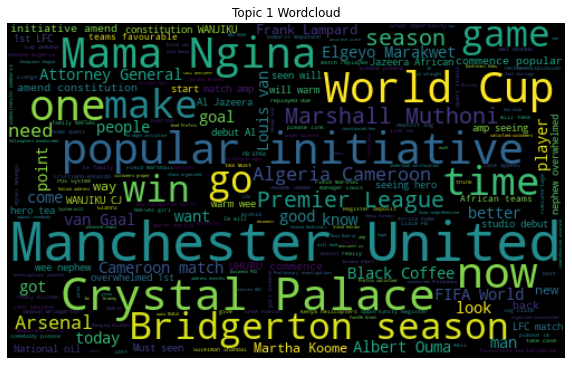

In [ ]:
## topic 0
topic0 = twitter_data[twitter_data['topic']==0]
all_words = ' '.join(twts for twts in topic0['cleaned_tweet'])

text_cloud = wordcloud.WordCloud(height=300,width=500,random_state=10,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.title('Topic 1 Wordcloud')
plt.imshow(text_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Topic 0 is infered to be entertainment and sports.

###6.2 Topic 1 Word Cloud

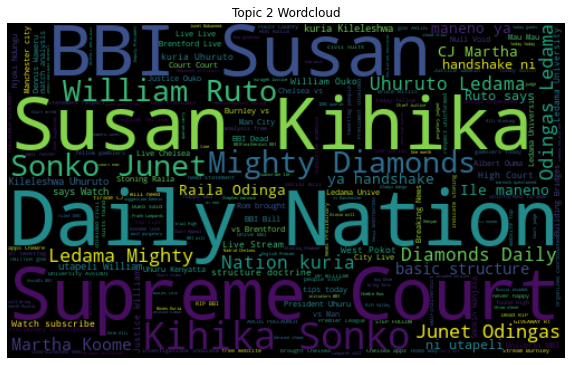

In [ ]:
## topic 1
topic0 = twitter_data[twitter_data['topic']==1]
all_words = ' '.join(twts for twts in topic0['cleaned_tweet'])

text_cloud = wordcloud.WordCloud(height=300,width=500,random_state=10,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.title('Topic 2 Wordcloud')
plt.imshow(text_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Topic 1 is inferred to be justice and constitutional reforms.

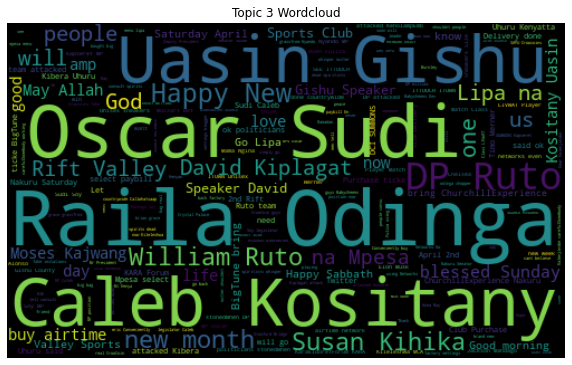

In [ ]:
## topic 2
topic0 = twitter_data[twitter_data['topic']==2]
all_words = ' '.join(twts for twts in topic0['cleaned_tweet'])

text_cloud = wordcloud.WordCloud(height=300,width=500,random_state=10,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,8))
plt.title('Topic 3 Wordcloud')
plt.imshow(text_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

Topic 2 is inferred to be politics and election violence.

## 7 Conclusion

- LDA with initialization of 3 topics had commendable results with less overlap between topics.
- Further analysis was also carried out to optimize the model.
- Given time we would have considered other algorithms such as Non-Negative matrix factorization.